In [1]:
import matplotlib.pyplot as plt
import numpy
%matplotlib inline
import scipy.interpolate
import topo_builder

In [2]:
# # Profile used at coasts
# x = numpy.linspace(-.25,1.25,100)
# x0 = 0; plt.axvline(x0, linestyle='--', color='k', label='x0')
# L = 1; plt.axvline(x0+L, linestyle='--', color='k', label='x0+L')
# lf = 0.125; plt.axvline(x0+lf*L, linestyle='--', color='b', label='x0+lf*L')
# bf = 0.125; plt.axvline(x0+(lf+bf)*L, linestyle='--', color='r', label='x0+(lf+bf)*L')
# sf = 0.5; plt.axvline(x0+(1-sf)*L, linestyle='--', color='g', label='x0+(1-sf)*L')
# sh = 0.05; plt.axhline(-sh, linestyle=':', label='sh')
# plt.plot(x, -topo_builder.topo.coastal_sprofile(x, x0, L, sh, lf, bf, sf) )
# plt.grid()
# plt.legend();

In [3]:
# NeverWorld2 domain
NW2_lonW, NW2_lonE = 0, 60
NW2_latS, NW2_latN = -70, 70

D0 = 4000 # Nominal depth (m)
cd = 200 # Depth of coastal shelf (m)
drake = 2500 # Depth of Drake sill (m)
cw = 5 # Width of coastal shelf (degrees)

# Logical domain (grid points)
nj, ni = 140, 60

In [4]:
def scurve(x, x0, dx):
    """Returns 0 for x<x0, 1 for x>x0+dx, and a cubic in between."""
    s = numpy.minimum(1, numpy.maximum(0, (x-x0)/dx))
    return (3 - 2*s)*( s*s )
def itau(ytau,taud,ys):
    """Returns a profile tau(ys) that uses s-curves between node,valuesa ytau,taud"""
    taus = 0.*ys
    ks = 0
    for i in range(len(ys)):
        y = ys[i]
        if y>=ytau[ks+1]:
            ks=min(len(ytau)-2,ks+1)
        taus[i] = taud[ks] + ( taud[ks+1] - taud[ks]) * scurve(y, ytau[ks], ytau[ks+1]-ytau[ks])
    return taus
ytau,taud = [-70,-45,-15,0,15,45,70], [0,.2,-0.1,-.02,-.1,.1,0]
ys = numpy.linspace(-70,70,100)
tau = itau(ytau, taud, ys)

In [5]:
# New profile for Neverworld2
h2 = numpy.array([25, 50, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 500, 550, 600])
print('Total depth =', h2.sum(), '# of layers =', h2.shape[0] )

print('h = ',end='')
for i in range(len(h2)): print(h2[i], end=', ')
print()
e2 = numpy.zeros( h2.shape[0]+1 )
e2[1:] = h2.cumsum()
ec2 = ( e2[:-1] + e2[1:] )/2
def rrr(e, d=1000, drho=5.5):
    fe = numpy.exp((4000-e)/d)
    fe = fe - fe[-1]
    fe = fe/fe[0]
    return 1028.1 - drho * fe
r2 = rrr(ec2).round(2)
print('Layer = ',end='')
for i in range(len(r2)): print(r2[i], end=', ')
print()
gp = 10*(r2[1:] - r2[:-1] )/1000
hb = ( h2[:-1] + h2[1:] )/2
print("g' (m/s2) = ",end='')
for i in range(len(gp)): print(gp[i].round(8), end=', ')
print()

Total depth = 4000 # of layers = 15
h = 25, 50, 100, 125, 150, 175, 200, 225, 250, 300, 350, 400, 500, 550, 600, 
Layer = 1022.6, 1022.81, 1023.2, 1023.74, 1024.32, 1024.9, 1025.47, 1026.0, 1026.48, 1026.9, 1027.27, 1027.58, 1027.82, 1027.99, 1028.1, 
g' (m/s2) = 0.0021, 0.0039, 0.0054, 0.0058, 0.0058, 0.0057, 0.0053, 0.0048, 0.0042, 0.0037, 0.0031, 0.0024, 0.0017, 0.0011, 


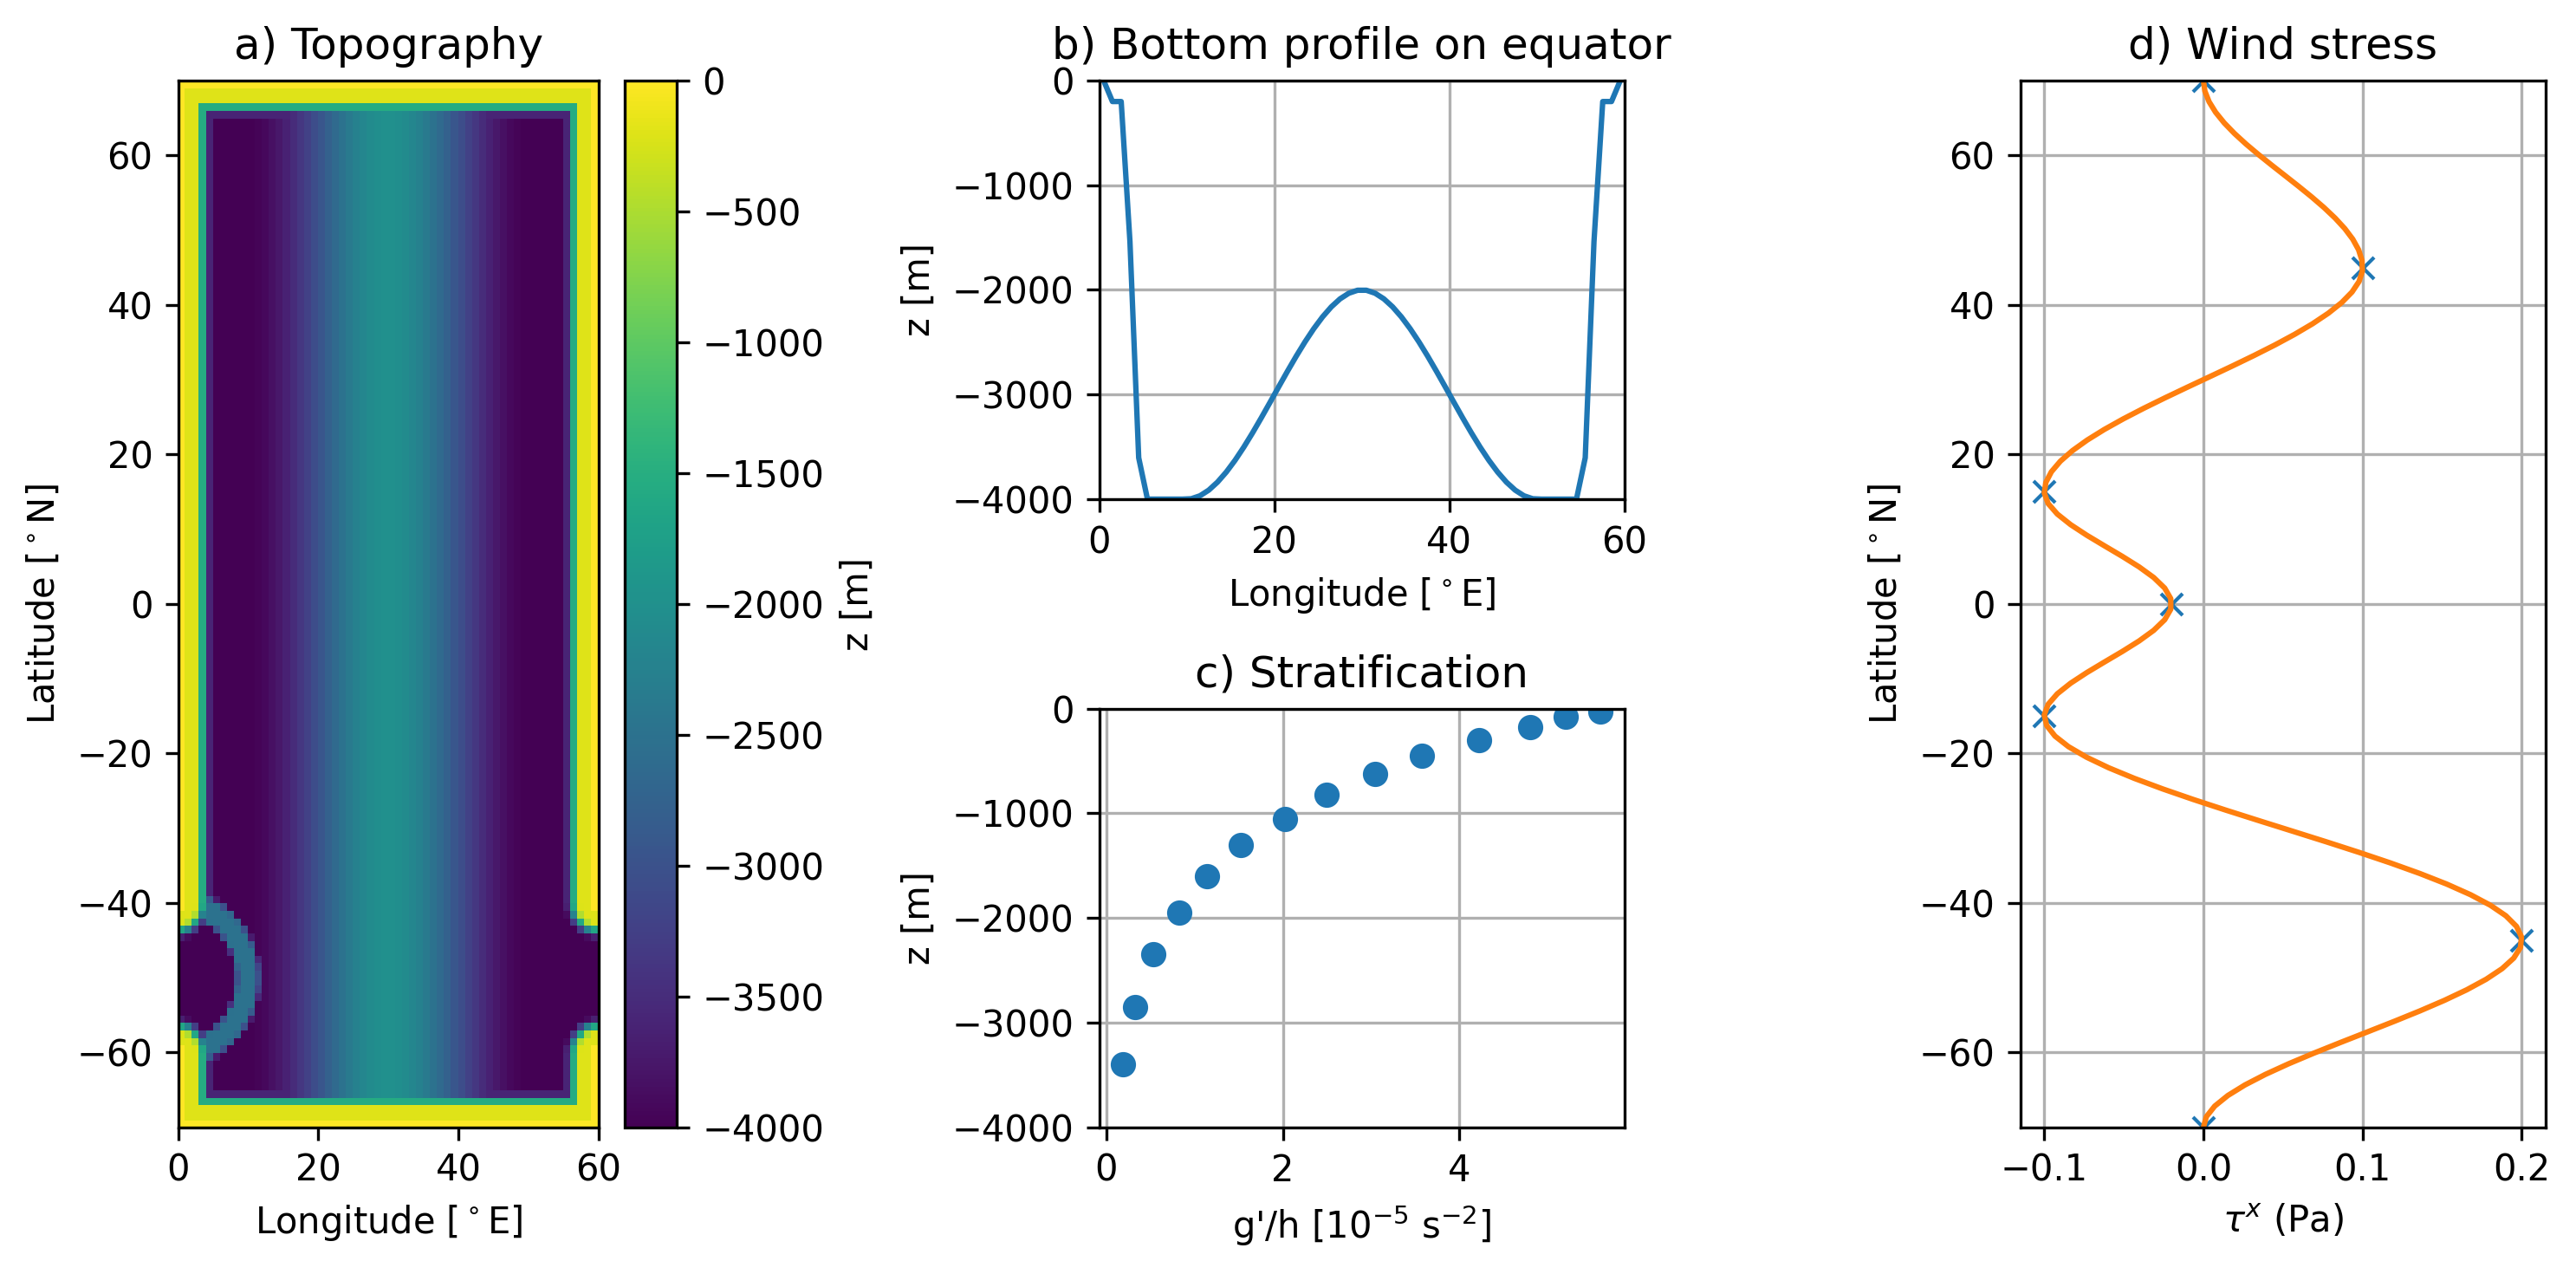

In [8]:
# Side-b-side comparison for discussion purposes
fig,axs = plt.subplots(1,1,figsize=(10,5),dpi=300)

T = topo_builder.topo(nj, ni, dlon=NW2_lonE, dlat=NW2_latN-NW2_latS, lat0=NW2_latS, D=D0)
T.add_NS_coast(NW2_lonW, -40, 90, cw, cd)
T.add_NS_coast(NW2_lonE, -40, 90, cw, cd)
T.add_NS_coast(NW2_lonW, -90, -60, cw, cd)
T.add_NS_coast(NW2_lonE, -90, -60, cw, cd)
T.add_EW_coast(-360, 360, NW2_latS, cw, cd)
T.add_EW_coast(-360, 360, NW2_latN, cw, cd)
T.add_circular_ridge(NW2_lonW, -50, 10, 2, drake) # Drake sill
T.add_NS_sridge(30, -90, 90, 20, D0/2) # Mid-Atlantic ridge?

plt.subplot(1,3,1)
im = plt.pcolormesh(T.xg, T.yg, T.z, vmin=-4000);
plt.xlabel('Longitude [$^\circ$E]');
plt.ylabel('Latitude [$^\circ$N]');
plt.title('a) Topography');
cb = plt.colorbar(label='z [m]')

plt.subplot(2,3,2)
plt.plot((T.xg[:-1]+T.xg[1:])/2, T.z[nj//2,:])
plt.xlabel('Longitude [$^\circ$E]');
plt.xlim(0,60)
plt.ylabel('z [m]')
plt.ylim(-4000,0)
plt.grid();
plt.title('b) Bottom profile on equator');

plt.subplot(2,3,5)
# plt.plot(r2, -ec2, 'o')
# plt.plot(numpy.vstack([r2,r2]), -numpy.vstack([e2[:-1],e2[1:]]), 'C0' );
# plt.xlabel('Layer density [kg m$^{-3}$]')
# plt.xlim(1022,1028.5)
plt.plot(gp/hb*1e5, -e2[1:-1], 'o')
# plt.plot(numpy.vstack([r2,r2]), -numpy.vstack([e2[:-1],e2[1:]]), 'C0' );
plt.xlabel("g'/h [10$^{-5}$ s$^{-2}$]")
# plt.xlim(1022,1028.5)
plt.ylabel('z [m]')
plt.ylim(-4000,0)
plt.grid();
plt.title('c) Stratification');

plt.subplot(1,3,3)
plt.plot(taud, ytau, 'x')
plt.plot(tau, ys)
plt.ylim(-70,70);
plt.ylabel('Latitude [$^\circ$N]');
plt.xlabel(r'$\tau^x$ (Pa)');
plt.grid();
plt.title('d) Wind stress');


plt.tight_layout()

# cb = fig.colorbar(im, ax=axs, orientation='vertical', fraction=.175)

plt.savefig('fig01-configuration.png')